<a href="https://colab.research.google.com/github/Swetha-kodam/20311a1990/blob/main/pcos%20diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flaml
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 6.3 MB/s eta 0:00:00


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from flaml import AutoML
import lightgbm as lgb
from imblearn.over_sampling import SMOTEN



In [6]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 120,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "pcos.log",
}


In [7]:
#Loding data into the kernels

file_path_with_infertility="/content/PCOS_infertility.csv"
file_path_without_infertility="/content/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

In [8]:
PCOS_inf.head()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [9]:
PCOS_woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [10]:
#Merging the two files as per patient file no.
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head()

<ipython-input-10-8847f38f7ca6>:3: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [11]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [12]:

#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head()

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [13]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [14]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values.
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

In [15]:
# Having a look at some basic statistical details.

data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


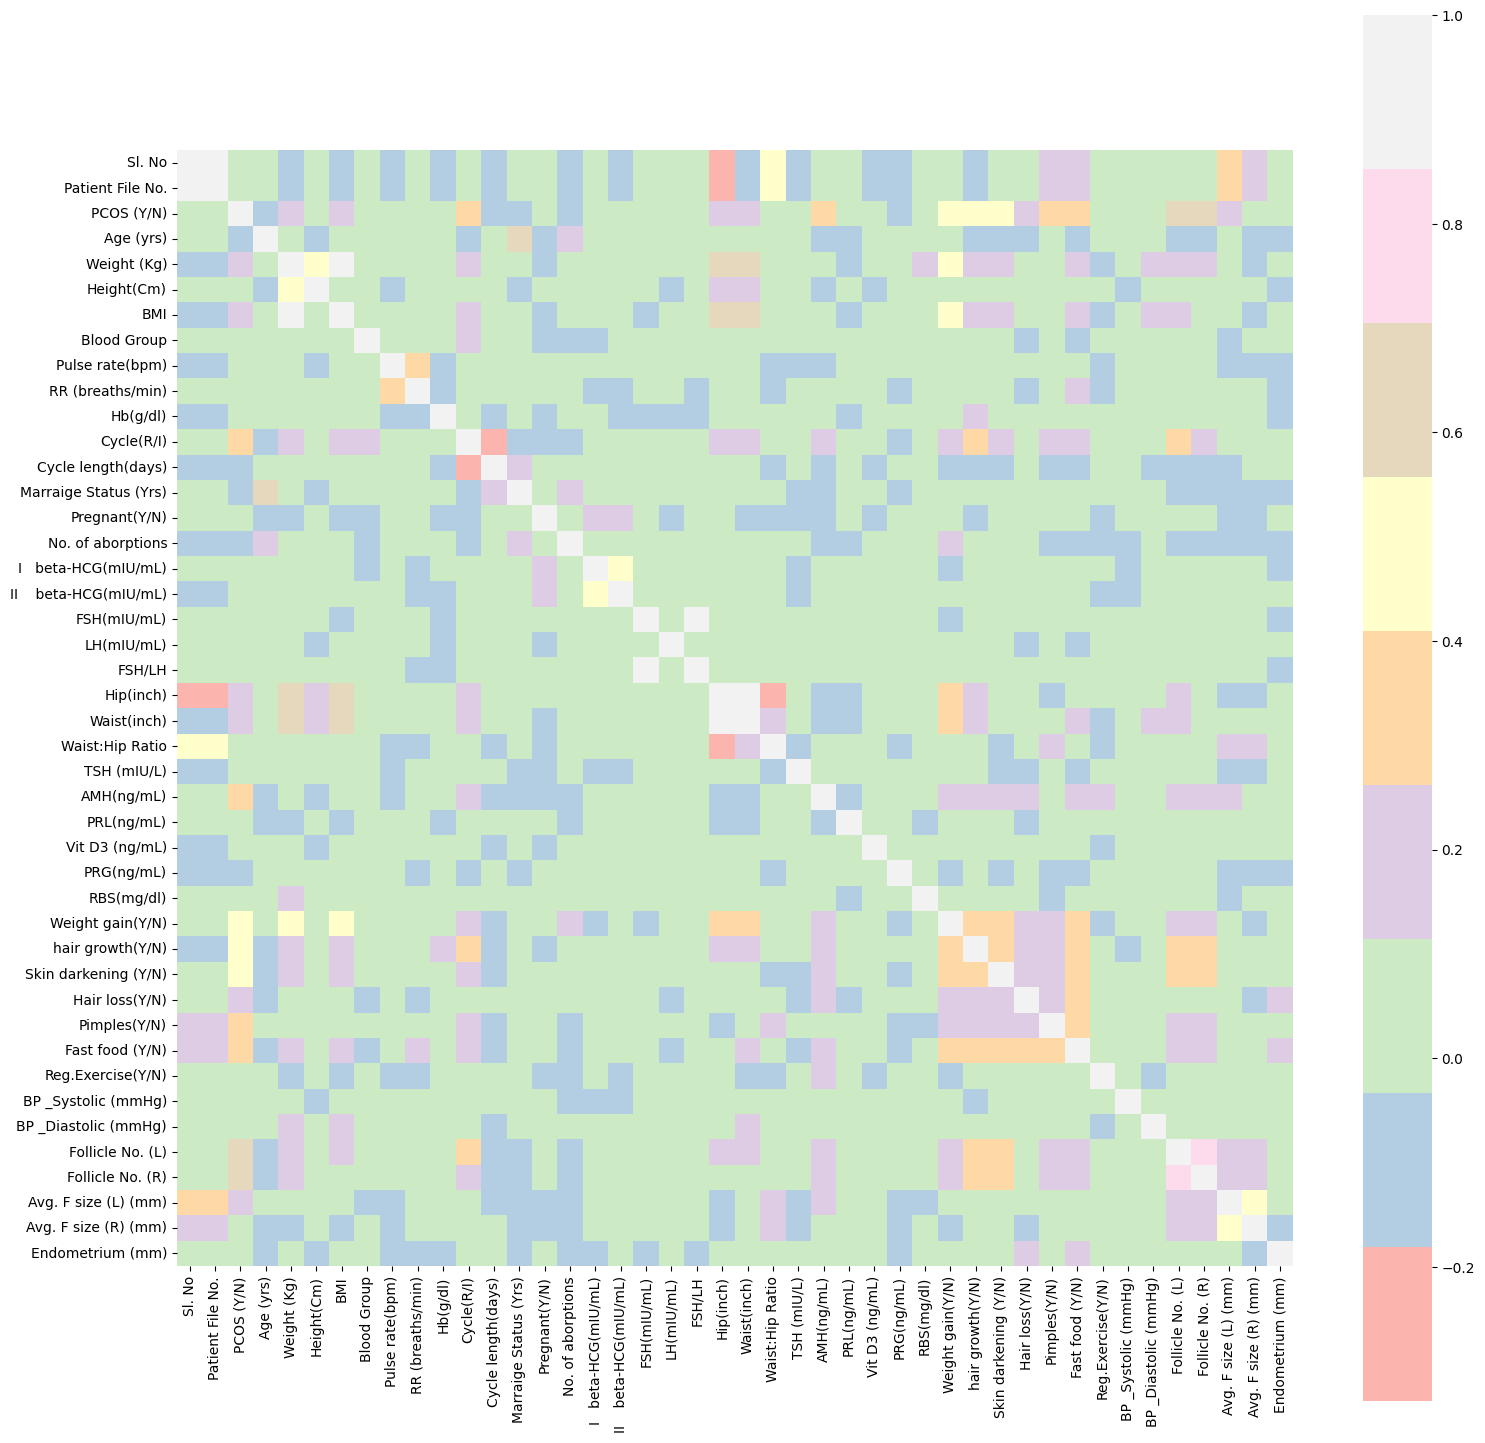

In [16]:
#Examaning a correlation matrix of all the features

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [17]:
#How all the features correlate with the PCOS

corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.648327
Follicle No. (L)          0.603346
Skin darkening (Y/N)      0.475733
hair growth(Y/N)          0.464667
Weight gain(Y/N)          0.441047
Cycle(R/I)                0.401644
Fast food (Y/N)           0.376183
Pimples(Y/N)              0.286077
AMH(ng/mL)                0.264141
Weight (Kg)               0.211938
BMI                       0.199534
Hair loss(Y/N)            0.172879
Waist(inch)               0.164598
Hip(inch)                 0.162297
Avg. F size (L) (mm)      0.132992
Endometrium (mm)          0.106648
Avg. F size (R) (mm)      0.097690
Pulse rate(bpm)           0.091821
Hb(g/dl)                  0.087170
Vit D3 (ng/mL)            0.085494
Height(Cm)                0.068254
Reg.Exercise(Y/N)         0.065337
LH(mIU/mL)                0.063879
Sl. No                    0.060998
Patient File No.          0.060998
RBS(mg/dl)                0.048922
BP _Diastolic (mmHg)      0.038032
RR (breaths/min)    

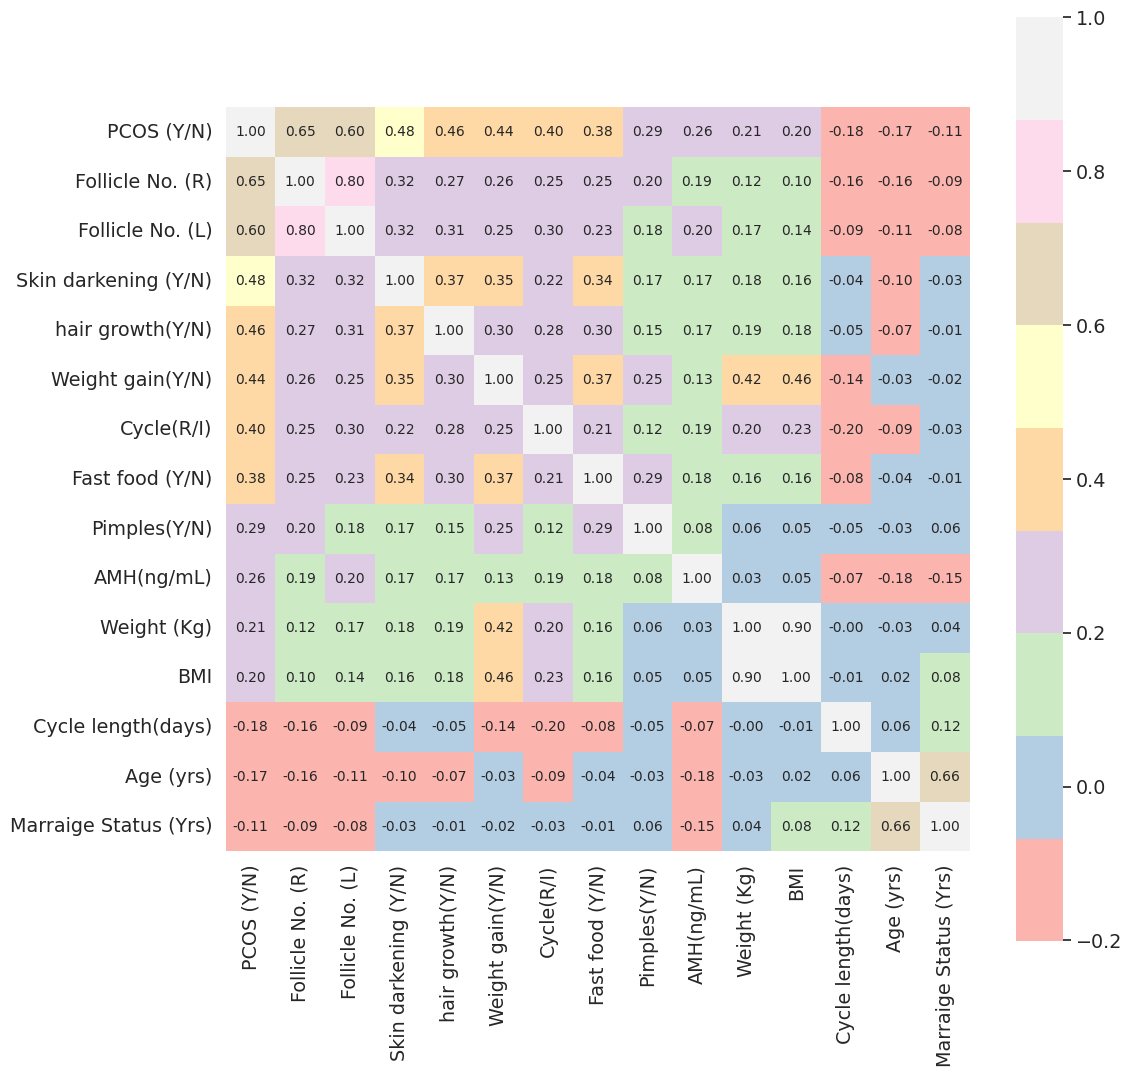

In [19]:
#Having a look at features bearing significant correlation
import numpy as np
plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n)

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

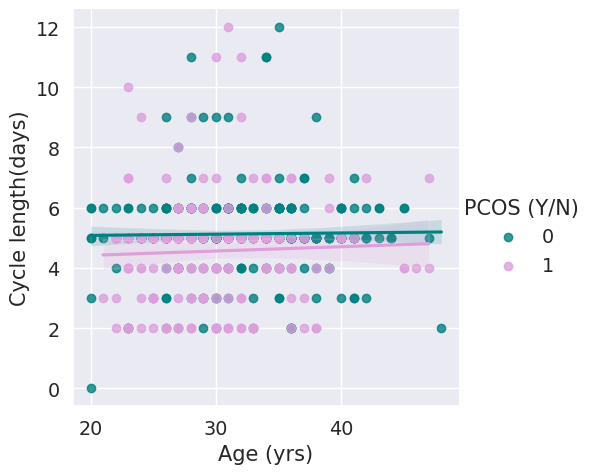

In [20]:
# Length of menstrual phase in PCOS vs normal
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

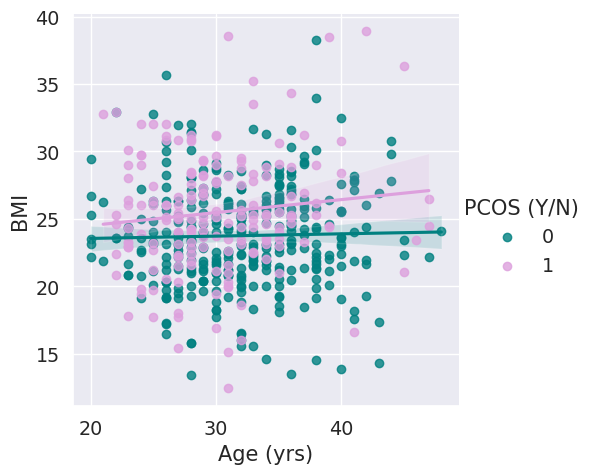

In [21]:
# Pattern of weight gain (BMI) over years in PCOS and Normal.
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

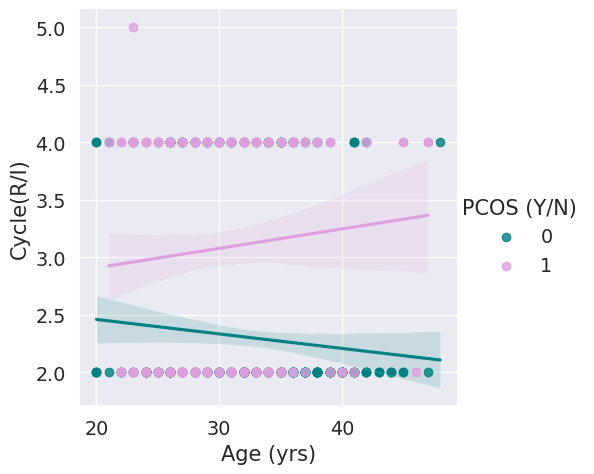

In [22]:
# cycle IR wrt age
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

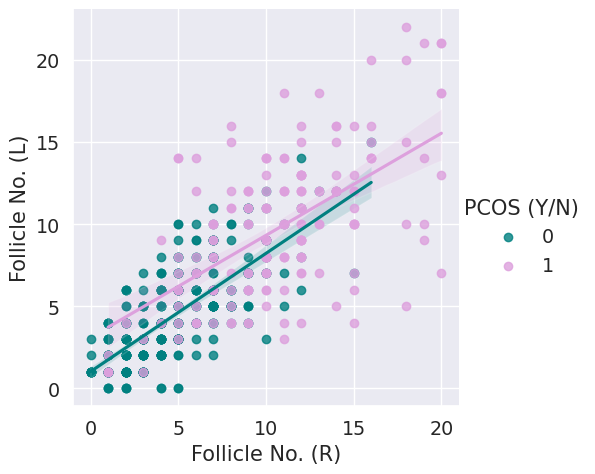

In [23]:
# Distribution of follicles in both ovaries.
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

<ipython-input-24-7abf845109c2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


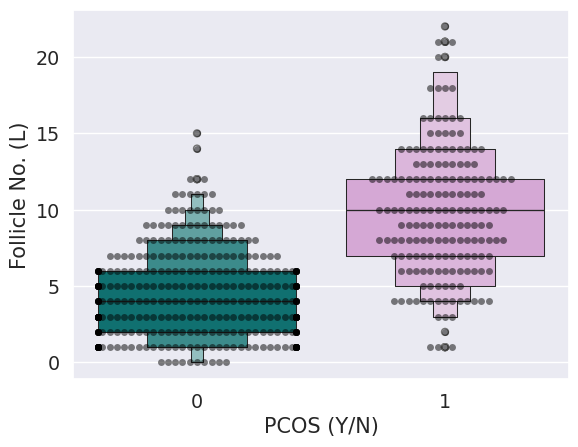

<ipython-input-24-7abf845109c2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


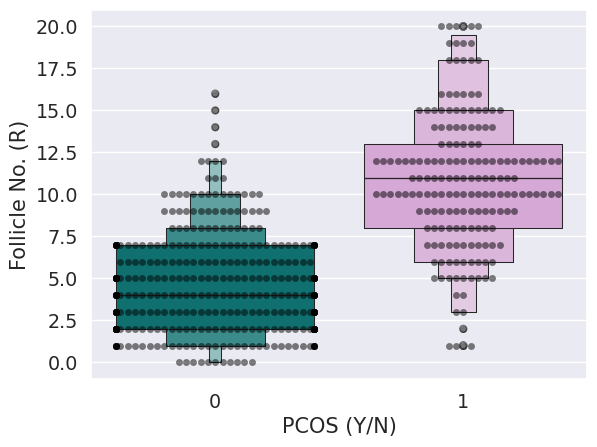

In [24]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


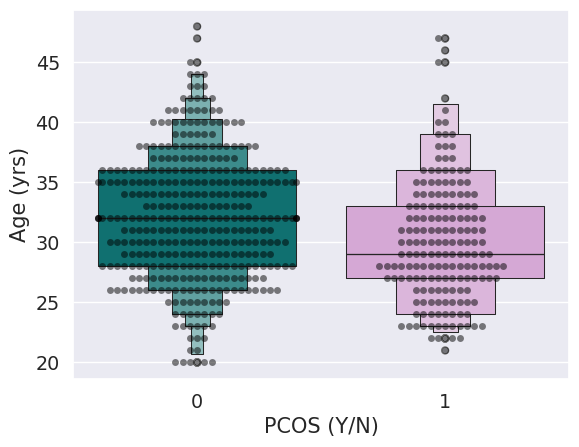

<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


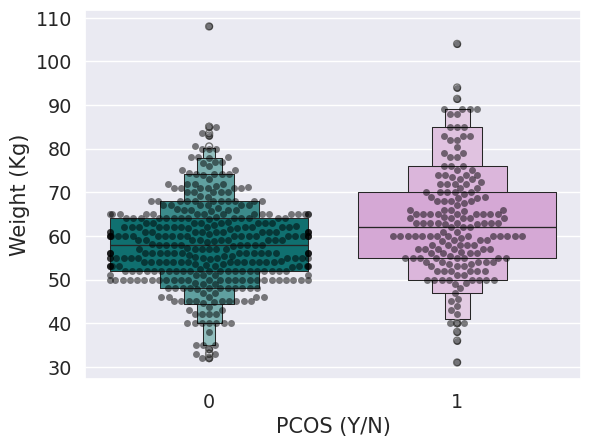

<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


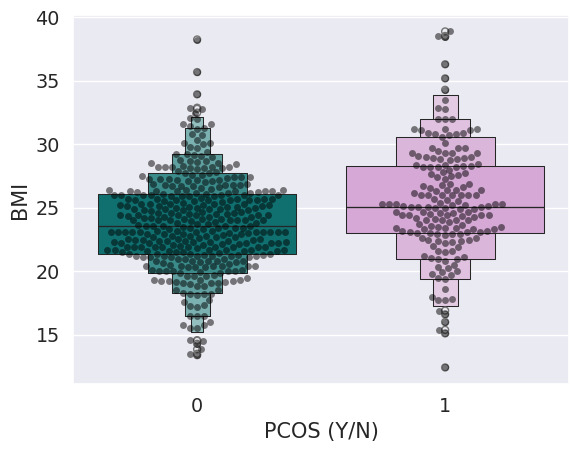

<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


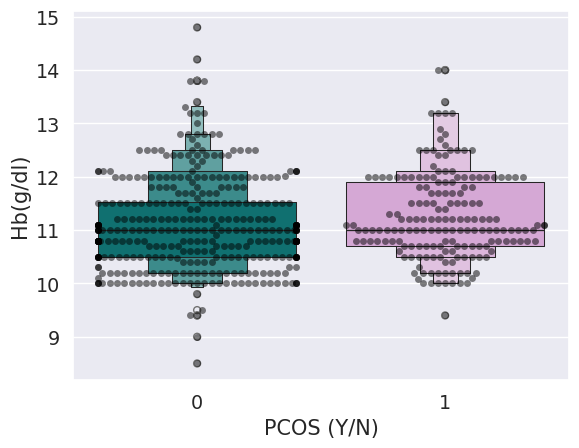

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 53.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 65.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categori

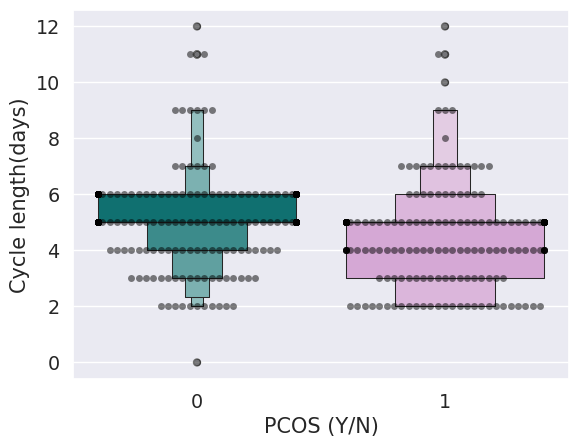

<ipython-input-25-484e90987139>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


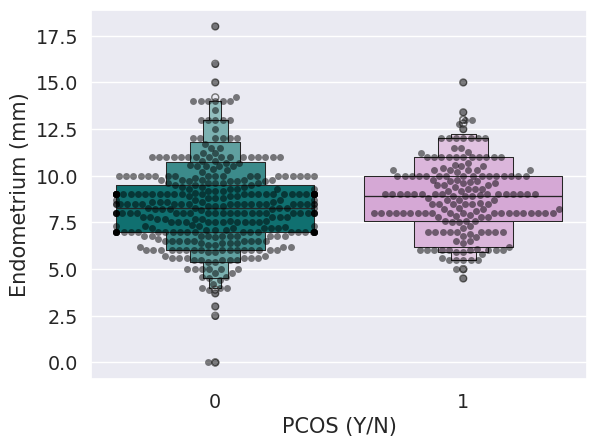

In [25]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

In [26]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

In [27]:
print(X.columns)

Index(['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 'Blood Group',
       'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)',
       'Cycle length(days)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)',
       'No. of aborptions', 'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)',
       'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)',
       'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)'],
      dtype='object')


[0.01640256 0.01424646 0.01242853 0.01216723 0.00962288 0.01228436
 0.01108337 0.01281636 0.05523953 0.02290163 0.01591161 0.00803866
 0.00715567 0.01337998 0.00941328 0.01077025 0.01678316 0.01140773
 0.0158962  0.0135172  0.01390388 0.01150022 0.0175402  0.01160682
 0.01116361 0.01105264 0.01091881 0.07127658 0.0899147  0.09259699
 0.01299877 0.03038647 0.04038818 0.01728921 0.01029673 0.00840691
 0.08819707 0.10702152 0.01499267 0.01589864 0.01118272]


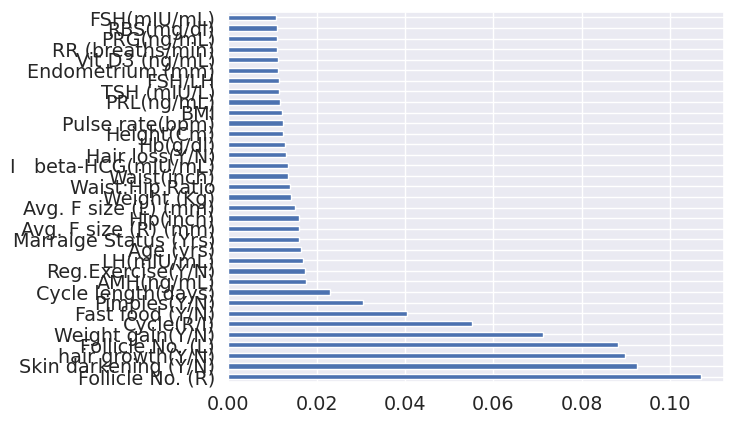

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).plot(kind='barh')
plt.rcParams["figure.figsize"] = (30,30)
plt.show()

In [29]:
fimp = feat_importances.nlargest(15)
df_again = data[fimp.index]
df_again

,Follicle No. (R),Skin darkening (Y/N),hair growth(Y/N),Follicle No. (L),Weight gain(Y/N),Cycle(R/I),Fast food (Y/N),Pimples(Y/N),Cycle length(days),AMH(ng/mL),Reg.Exercise(Y/N),LH(mIU/mL),Age (yrs),Marraige Status (Yrs),Avg. F size (R) (mm)
0,3,0,0,3,0,2,1.0,0,5,2.07,0,3.68,28,7.0,18.0
1,5,0,0,3,0,2,0.0,0,5,1.53,0,1.09,36,11.0,14.0
2,15,0,0,13,0,2,1.0,1,5,6.63,0,0.88,33,10.0,20.0
3,2,0,0,2,0,2,0.0,0,5,1.22,0,2.36,37,4.0,14.0
4,4,0,0,3,0,2,0.0,0,5,2.26,0,0.90,25,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,0,0,1,0,2,0.0,0,5,1.70,0,1.81,35,8.0,10.0
537,7,0,0,9,1,2,0.0,0,5,5.60,0,2.84,30,4.0,18.0
538,0,0,0,1,0,2,0.0,0,6,3.70,0,2.78,36,8.0,9.0
539,6,0,0,7,0,4,0.0,1,2,5.20,0,4.33,27,2.0,16.0


In [30]:
sm = SMOTEN(random_state=42)

X_sm, y_sm = sm.fit_resample(df_again, y)

X_sm=pd.DataFrame(X_sm,
             columns=df_again.columns)
y_sm=pd.DataFrame(y_sm, columns=['PCOS (Y/N)'])


print('New balance of 1 and 0 classes (%):')
y_sm.value_counts()

New balance of 1 and 0 classes (%):


PCOS (Y/N)
0             364
1             364
dtype: int64

In [31]:
#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=12)

In [32]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [33]:
automl.fit(X_train=X_train, y_train=y_train,X_val=X_test, y_val=y_test,**automl_settings)

[flaml.automl.logger: 02-06 18:22:50] {1679} INFO - task = classification
[flaml.automl.logger: 02-06 18:22:50] {1687} INFO - Data split method: stratified
[flaml.automl.logger: 02-06 18:22:50] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-06 18:22:50] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 02-06 18:22:50] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 02-06 18:22:50] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-06 18:22:51] {2344} INFO - Estimated sufficient time budget=5274s. Estimated necessary time budget=122s.
[flaml.automl.logger: 02-06 18:22:51] {2391} INFO -  at 0.7s,	estimator lgbm's best error=0.1187,	best estimator lgbm's best error=0.1187
[flaml.automl.logger: 02-06 18:22:51] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-06 18:22:51] {2391} INFO -  at 0.7s,	estimator lgbm's best 

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 02-06 18:24:50] {2391} INFO -  at 120.0s,	estimator lrl1's best error=0.1324,	best estimator rf's best error=0.0274
[flaml.automl.logger: 02-06 18:24:50] {2493} INFO - selected model: RandomForestClassifier(max_features=0.10900353669355439, max_leaf_nodes=22,
                       n_estimators=28, n_jobs=-1, random_state=12032022)
[flaml.automl.logger: 02-06 18:24:50] {1930} INFO - fit succeeded
[flaml.automl.logger: 02-06 18:24:50] {1931} INFO - Time taken to find the best model: 25.250741958618164


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [34]:
print(automl.model.estimator)

RandomForestClassifier(max_features=0.10900353669355439, max_leaf_nodes=22,
                       n_estimators=28, n_jobs=-1, random_state=12032022)


In [35]:
rfc = lgb.LGBMClassifier(learning_rate=0.3374329294340775, max_bin=1023,
               min_child_samples=8, n_estimators=9, num_leaves=9,
               reg_alpha=0.0009765625, reg_lambda=4.305658316786484,
               verbose=-1)
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.9269406392694064


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

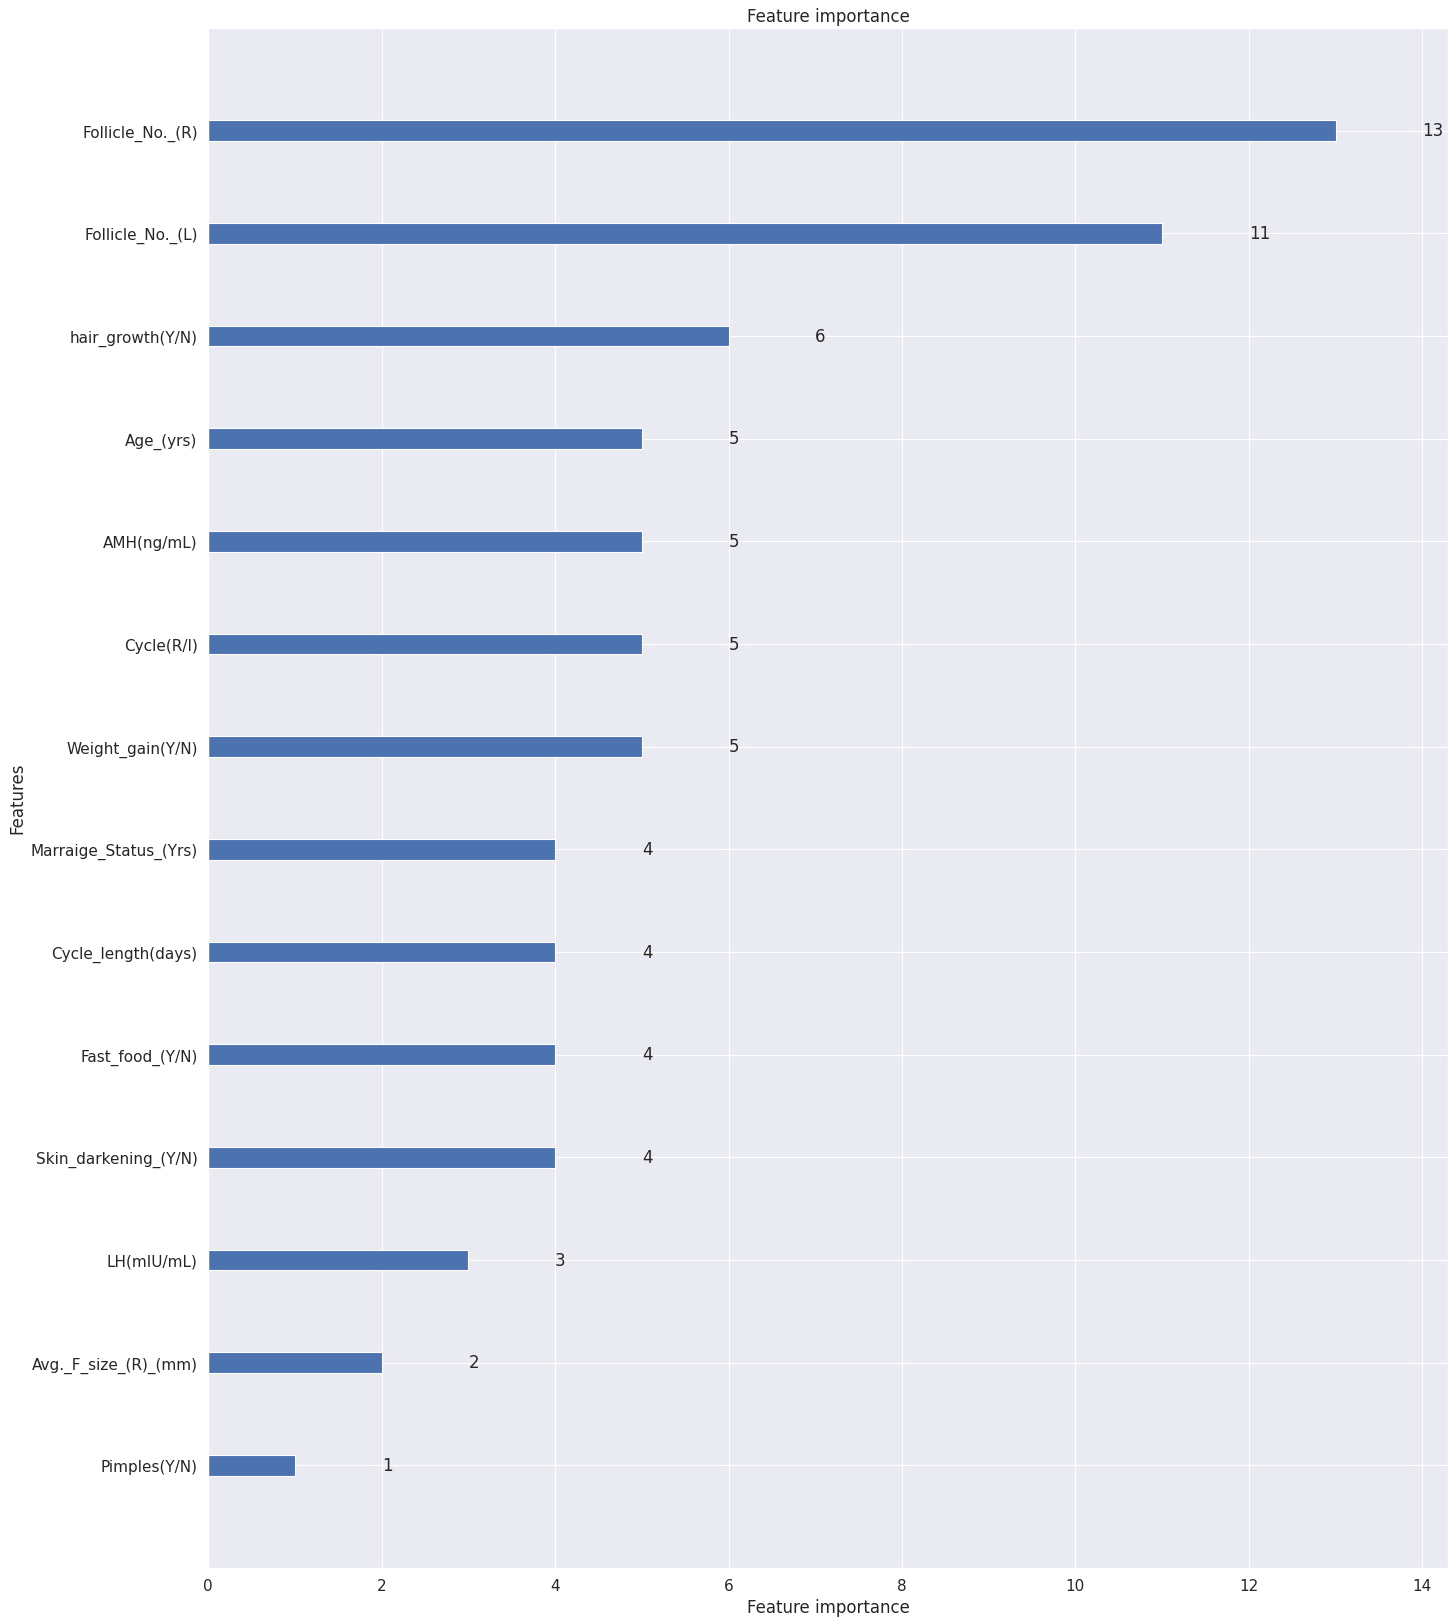

In [36]:
lgb.plot_importance(rfc, dpi=80, figsize=(20,25)) # Explainable AI

In [37]:
classi_report = classification_report(y_test, pred_rfc)
print(classi_report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       102
           1       0.92      0.94      0.93       117

    accuracy                           0.93       219
   macro avg       0.93      0.93      0.93       219
weighted avg       0.93      0.93      0.93       219



<Axes: >

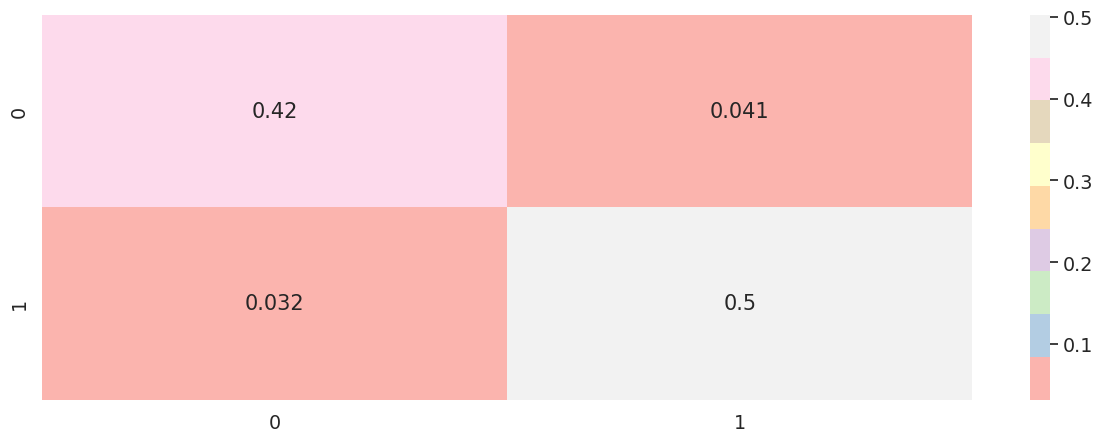

In [38]:
# cofusion matrix
plt.subplots(figsize=(15,5))
cf_matrix = confusion_matrix(y_test, pred_rfc)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15}, cmap = 'Pastel1')

In [39]:
save_to = '{}.txt'.format('pcos_model')
rfc.booster_.save_model(save_to)